In [1]:
import pygmt
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import griddata
import xarray as xr
import netCDF4
from netCDF4 import Dataset
import matplotlib.pyplot as plt

In [2]:
df_moho = pd.read_csv("moho_depth.csv")
df_moho

,Latitude,Longitude,Moho
0,-90.00,0.00,38.0
1,-90.00,140.00,26.0
2,-89.93,144.36,40.0
3,-89.93,145.00,39.0
4,-87.42,-149.43,35.0
...,...,...,...
81102,-89.50,175.50,39.0
81103,-89.50,176.50,39.0
81104,-89.50,177.50,39.0
81105,-89.50,178.50,39.0


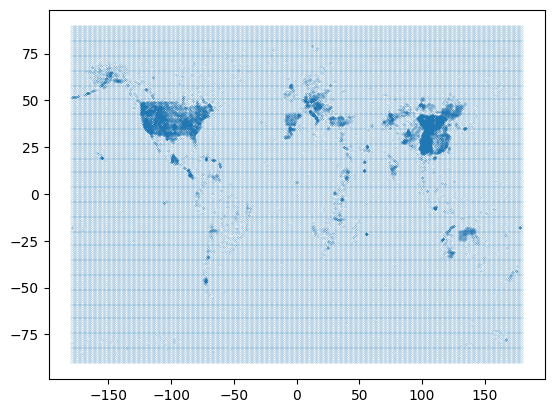

In [3]:
plt.scatter(x=df_moho['Longitude'],y=df_moho['Latitude'],s=0.01)

In [4]:
ds = df_moho.to_xarray()
print (ds)

<xarray.Dataset> Size: 3MB
Dimensions:    (index: 81107)
Coordinates:
  * index      (index) int64 649kB 0 1 2 3 4 5 ... 81102 81103 81104 81105 81106
Data variables:
    Latitude   (index) float64 649kB -90.0 -90.0 -89.93 ... -89.5 -89.5 -89.5
    Longitude  (index) float64 649kB 0.0 140.0 144.4 145.0 ... 177.5 178.5 179.5
    Moho       (index) float64 649kB 38.0 26.0 40.0 39.0 ... 39.0 39.0 39.0 39.0


In [5]:
# Step 1: Load your dataframe (ensure df_moho is already defined)
df = df_moho.copy()

# Step 2: Define the target grid
lat_grid = np.arange(-90, 90.1, 0.5)
lon_grid = np.arange(-180, 180.1, 0.5)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Step 3: Interpolate the data
grid_z = griddata(
    points=(df['Longitude'], df['Latitude']),
    values=df['Moho'],
    xi=(lon_mesh, lat_mesh),
    method='linear'
)

# Step 4: Create DataArray (do not add attrs here yet)
data_array = xr.DataArray(
    grid_z,
    coords={'Latitude': lat_grid, 'Longitude': lon_grid},
    dims=['Latitude', 'Longitude'],
    name='Moho'
)

# Step 5: Wrap in Dataset
ds = data_array.to_dataset()

# Step 6: Add variable-level metadata (must be done after to_dataset)
ds['Moho'].attrs = {
    'units': 'km',
    'long_name': 'Moho Depth',
    'standard_name': 'moho_depth',
    'actual_range': [float(np.nanmin(grid_z)), float(np.nanmax(grid_z))],
    '_FillValue': np.nan,  # Important for GMT/PyGMT compatibility
    'coordinates': 'Latitude Longitude',  # Indicate that these coordinates correspond to lat/lon
}

# Step 7: Add coordinate variable metadata
ds['Latitude'].attrs = {
    'units': 'degrees_north',
    'long_name': 'Latitude',
    'axis': 'Y'
}
ds['Longitude'].attrs = {
    'units': 'degrees_east',
    'long_name': 'Longitude',
    'axis': 'X'
}

# Step 8: Add global metadata
ds.attrs = {
    'title': 'Gridded Moho Depth',
    'summary': 'Interpolated onto regular 0.5x0.5 lat-lon grid',
    #'Conventions': 'CF-1.6',
    'creator_name': 'Your Name or Organization',  # Add creator info
    'institution': 'Your Institution',  # Add institution info
    'source': 'Original dataset details (e.g., source of Moho data)',  # Add data source info
    'history': 'Data processed using griddata method for interpolation',  # Add processing info
    'date_created': str(pd.to_datetime('today'))  # Add date of creation
}

# Step 9: Save as NetCDF
ds.to_netcdf('global_moho.nc', format='NETCDF4')


In [10]:
# Read grid information using grdinfo
grid = pygmt.grdinfo("global_moho.nc")

print(grid)

global_moho.nc: Title: Gridded Moho Depth
global_moho.nc: Command: Data processed using griddata method for interpolation
global_moho.nc: Remark: 
global_moho.nc: Gridline node registration used [Geographic grid]
global_moho.nc: Grid file format: nd = GMT netCDF format (64-bit float), CF-1.7
global_moho.nc: x_min: -180 x_max: 180 x_inc: 0.5 (30 min) name: Longitude n_columns: 721
global_moho.nc: y_min: -90 y_max: 90 y_inc: 0.5 (30 min) name: Latitude n_rows: 361
global_moho.nc: v_min: 4.13 v_max: 89.3403186268 name: Moho Depth [km]
global_moho.nc: scale_factor: 1 add_offset: 0
global_moho.nc: format: netCDF-4 chunk_size: 0,0 shuffle: off deflation_level: 0
global_moho.nc: Default CPT: 



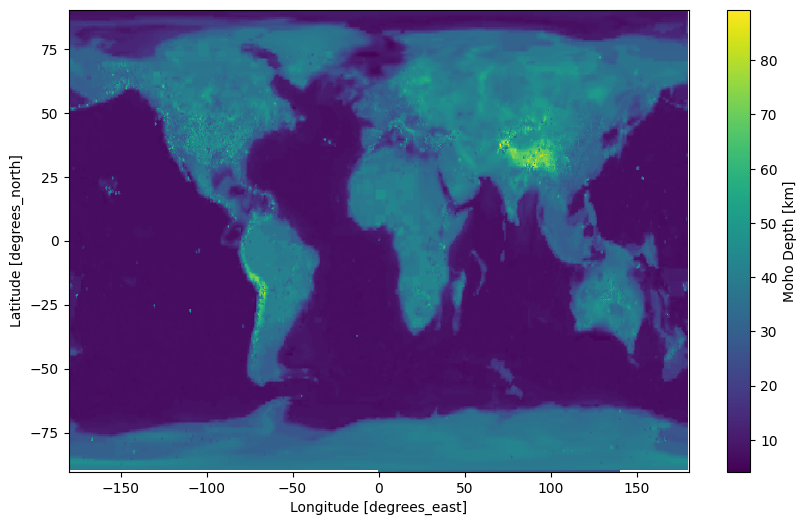

In [7]:
ds = xr.open_dataset('global_moho.nc')
ds['Moho'].plot(figsize=(10,6))


In [8]:
ds['Moho'].min().item(), ds['Moho'].max().item()


(4.13, 89.3403186267959)

In [9]:
# Open the NetCDF file
nc_file = 'global_moho.nc'  # Replace with your actual file path
dataset = Dataset(nc_file, 'r')

# Extract the variables
latitude = dataset.variables['Latitude'][:]
longitude = dataset.variables['Longitude'][:]
moho = dataset.variables['Moho'][:]

# Create a 2D grid of latitude and longitude
latitudes, longitudes = np.meshgrid(latitude, longitude)

# Flatten the grid to create a 1D list of latitudes, longitudes, and Moho values
latitudes_flat = latitudes.flatten()
longitudes_flat = longitudes.flatten()
moho_flat = moho.flatten()

# Create a DataFrame
df = pd.DataFrame({
    'Latitude': latitudes_flat,
    'Longitude': longitudes_flat,
    'Moho': moho_flat
})

# Save the DataFrame to a CSV file
df.to_csv('gridded_moho.txt', index=False, sep='\t')  # Save as a tab-separated text file
